## 采用 scikit-learn 中的 AdaBoostClassifier 对葡萄酒数据集进行预测

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
# 禁用所有警告
warnings.filterwarnings('ignore', category=FutureWarning)

### 1. 导入数据集：葡萄酒数据集


In [2]:


# 导入葡萄酒数据集
data = load_wine()
X = data.data
y = data.target

# 显示数据集的基本信息
print(f"数据集特征：{data.feature_names}")
print(f"数据集标签：{data.target_names}")
print(f"样本数：{X.shape[0]}, 特征数：{X.shape[1]}")


数据集特征：['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
数据集标签：['class_0' 'class_1' 'class_2']
样本数：178, 特征数：13


### 2. 模型建立：使用 AdaBoostClassifier 建立分类模型（参数默认）

In [3]:
# 使用默认参数建立 AdaBoostClassifier 模型
model = AdaBoostClassifier()

# 使用交叉验证计算模型评分
cv_scores = cross_val_score(model, X, y, cv=5)  # 5折交叉验证


### 3. 输出：模型评分（使用交叉验证得到模型的综合评分）

In [4]:
# 输出交叉验证的结果
print(f"交叉验证的准确率：{cv_scores}")
print(f"平均准确率：{np.mean(cv_scores)}")


交叉验证的准确率：[0.69444444 0.91666667 0.91666667 0.54285714 0.97142857]
平均准确率：0.8084126984126984


### 【讨论一】模型在葡萄酒数据集上的表现如何？是过拟合还是欠拟合？

根据交叉验证的结果，我们可以初步判断模型的表现。如果交叉验证结果稳定且准确率较高，那么可以认为模型表现良好。如果训练集和验证集的差距很大，则可能存在过拟合。

- **过拟合**：训练集准确率高，而交叉验证准确率低。
- **欠拟合**：训练集和交叉验证集的准确率都较低，模型无法捕捉到数据的复杂性。


### 【讨论二】如何提升模型性能？模型超参数对性能有何影响？

为了提升模型性能，可以尝试调整AdaBoost的超参数，尤其是`n_estimators`和`learning_rate`。此外，可以比较不同的求解算法（"SAMME"和"SAMME.R"）对模型性能的影响。

In [5]:
# 不同的求解算法对比
model_samme = AdaBoostClassifier(algorithm='SAMME')
model_samme_r = AdaBoostClassifier(algorithm='SAMME.R')

# 比较不同算法的性能
cv_scores_samme = cross_val_score(model_samme, X, y, cv=5)
cv_scores_samme_r = cross_val_score(model_samme_r, X, y, cv=5)

print(f"SAMME算法的平均准确率：{np.mean(cv_scores_samme)}")
print(f"SAMME.R算法的平均准确率：{np.mean(cv_scores_samme_r)}")



SAMME算法的平均准确率：0.9333333333333332
SAMME.R算法的平均准确率：0.8084126984126984


### 【讨论三】通过学习曲线分析 AdaBoost 算法中的 `n_estimators` 参数对模型性能的影响

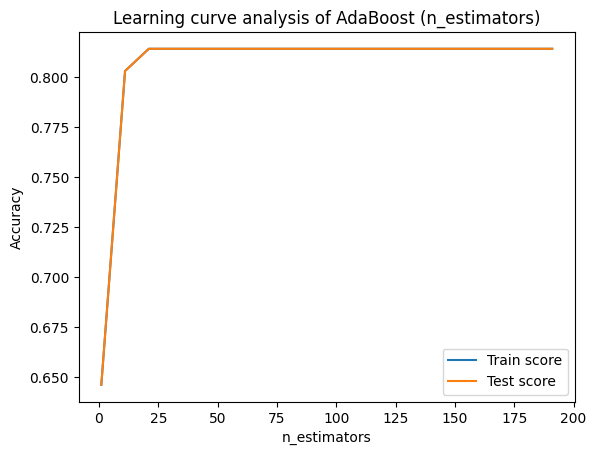

In [6]:
# 学习曲线分析 n_estimators 参数
n_estimators_range = range(1, 201, 10)
train_scores, test_scores = [], []

for n in n_estimators_range:
    model = AdaBoostClassifier(n_estimators=n)
    train_score = np.mean(cross_val_score(model, X, y, cv=5, scoring='accuracy'))
    test_score = np.mean(cross_val_score(model, X, y, cv=5, scoring='accuracy'))
    train_scores.append(train_score)
    test_scores.append(test_score)

# 绘制学习曲线
plt.plot(n_estimators_range, train_scores, label="Train score")
plt.plot(n_estimators_range, test_scores, label="Test score")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning curve analysis of AdaBoost (n_estimators)')
plt.show()


### 【讨论四】通过学习曲线分析 AdaBoost 算法中的 `learning_rate` 参数对模型性能的影响

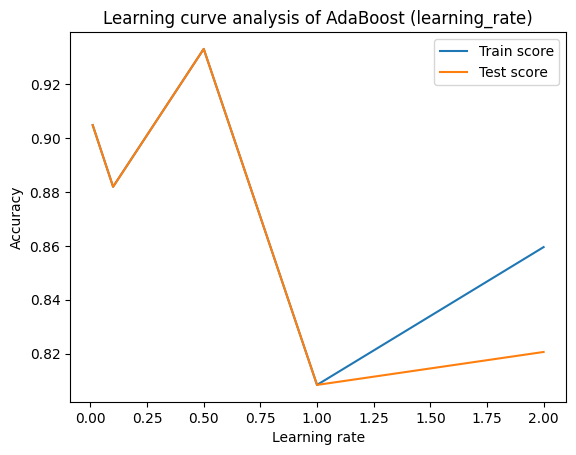

In [7]:
# 学习曲线分析 learning_rate 参数
learning_rate_range = [0.01, 0.1, 0.5, 1, 2]
train_scores, test_scores = [], []

for lr in learning_rate_range:
    model = AdaBoostClassifier(learning_rate=lr, n_estimators=50)
    train_score = np.mean(cross_val_score(model, X, y, cv=5, scoring='accuracy'))
    test_score = np.mean(cross_val_score(model, X, y, cv=5, scoring='accuracy'))
    train_scores.append(train_score)
    test_scores.append(test_score)

# 绘制学习曲线
plt.plot(learning_rate_range, train_scores, label="Train score")
plt.plot(learning_rate_range, test_scores, label="Test score")
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning curve analysis of AdaBoost (learning_rate)')
plt.show()


### 【讨论五】综合进行超参数选择，找到最好的一组超参数，在交叉验证集上验证模型效果，并与其他算法（决策树、随机森林等）进行对比

我们可以使用`GridSearchCV`或`RandomizedSearchCV`进行超参数调优，找到最佳的超参数组合，并与其他算法（如决策树和随机森林）进行对比。

In [8]:
# 定义要调优的超参数空间
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1],
}

# 使用GridSearchCV进行超参数调优
grid_search = GridSearchCV(AdaBoostClassifier(), param_grid, cv=5)
grid_search.fit(X, y)

# 输出最佳超参数组合
print(f"最佳超参数：{grid_search.best_params_}")
print(f"最佳交叉验证得分：{grid_search.best_score_}")

# 与其他算法进行比较
models = {
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate=0.1),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
}

for name, model in models.items():
    cv_score = np.mean(cross_val_score(model, X, y, cv=5))
    print(f"{name} 的交叉验证得分：{cv_score}")

最佳超参数：{'learning_rate': 0.5, 'n_estimators': 50}
最佳交叉验证得分：0.9330158730158731
AdaBoost 的交叉验证得分：0.8765079365079366
Decision Tree 的交叉验证得分：0.8709523809523809
Random Forest 的交叉验证得分：0.9777777777777779


### 总结

1. **模型表现分析**：通过交叉验证来观察AdaBoost模型是否存在过拟合或欠拟合。
2. **模型提升方法**：调整超参数（如`n_estimators`和`learning_rate`）来提高模型性能，并比较不同的求解算法对模型表现的影响。
3. **学习曲线分析**：分析`n_estimators`和`learning_rate`对模型性能的影响，了解这些参数的作用。
4. **超参数选择**：通过GridSearchCV找到最佳超参数组合，并与其他常见的分类算法进行比较。

这种方法可以有效地帮助你理解AdaBoost分类器在葡萄酒数据集上的表现，并通过调整超参数来优化其性能。